<a href="https://colab.research.google.com/github/YoTaSo/datascience/blob/main/rl/DQN_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/RLD/TME4'
os.chdir(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#env = gym.make('CartPole-v0')
import gridworld
env = gym.make("gridworld-v0")
#env = gym.make('LunarLander-v2')

In [ ]:
is_ipython=False

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
	def __init__(self,inSize,outSize,layers=[]):
		super(DQN,self).__init__()
		self.layers=nn.ModuleList([])
		for x in layers:
			self.layers.append(nn.Linear(inSize,x))
			inSize =x
		self.layers.append(nn.Linear(inSize,outSize))
	def forward(self,x):
		x=self.layers[0](x)
		for i in range(1,len(self.layers)):
			x=torch.nn.functional.leaky_relu(x)
			x=self.layers[i](x)
		return x

In [ ]:
env1 = gym.make('CartPole-v0')
env1.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.01842647, -0.04129826,  0.01141202, -0.03363641])

In [ ]:
#Features Extractor Gridworld environment
class FeaturesExtractor(object):
	def __init__(self,outSize):
		super().__init__()
		self.outSize=outSize*3
	def getFeatures(self,obs):
		state=np.zeros((3,np.shape(obs)[0],np.shape(obs)[1]))
		state[0]=np.where(obs==2,1,state[0])
		state[1]=np.where(obs==4,1,state[1])
		state[2]=np.where(obs==6,1,state[2])
		return state.reshape(1,-1)

In [ ]:
fexGrid=FeaturesExtractor(1)
obs=env.reset()
zz=fexGrid.getFeatures(obs)

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 20#10

# Get number of actions from gym action space
n_actions = env.action_space.n
#state_dim=len(env.reset())
state_dim=zz.shape[1]
hidden_layers=[3]

policy_net = DQN(state_dim, n_actions,hidden_layers).to(device)
target_net = DQN(state_dim, n_actions,hidden_layers).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():

            return policy_net(state).argmax().view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
memory.memory=[]
memory.position=0

In [ ]:
num_episodes = 10000
rewards=[]
episode_durations=[]
for i_episode in range(num_episodes):
    # Initialize the environment and state
    
    rsum = 0
    #state = torch.from_numpy(env.reset()).float().view(1,-1).to(device)
    state = torch.from_numpy(fexGrid.getFeatures(env.reset())).float().view(1,-1).to(device)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        obs, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        #obs=torch.from_numpy(obs).float().view(1,-1).to(device)
        obs=torch.from_numpy(fexGrid.getFeatures(obs)).float().view(1,-1).to(device)

        if not done:
            next_state = obs
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        rsum += reward
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            rewards.append( rsum)
            #plot_durations()
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
#env.render()
env.close()
plt.ioff()
plt.show()

KeyboardInterrupt: ignored

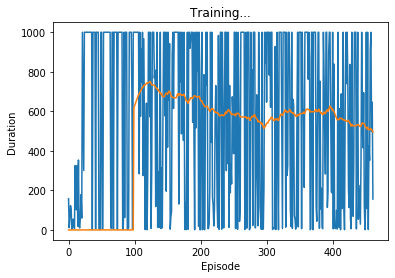

In [ ]:
plot_durations()

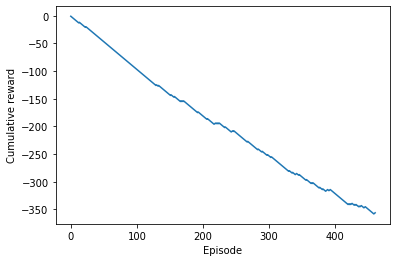

In [ ]:
plt.plot(np.cumsum(rewards))
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.show()